# Fraud Detection Predictions

### Loading libraries

In [1]:
!pip install xgboost

In [2]:
import s3fs
import sagemaker
import boto3
import os
import shap
import json
import pandas as pd
import joblib
import numpy as np
import matplotlib.pyplot as plt
from sagemaker.session import Session
from sagemaker.sklearn import SKLearnModel
from sagemaker import get_execution_role
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sagemaker.inputs import TrainingInput
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.serializers import CSVSerializer
import xgboost as xgboost


import warnings
warnings.filterwarnings('ignore')

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


[03/25/25 18:09:48] INFO     Found credentials from IAM Role:                                   ]8;id=378289;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=655387;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


### Defining IAM role and s3 bucket

In [3]:
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
region = sagemaker_session.boto_region_name

[03/25/25 18:09:51] INFO     Found credentials from IAM Role:                                   ]8;id=747728;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=506994;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

                    INFO     Found credentials from IAM Role:                                   ]8;id=77403;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=364460;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

### Processing Data

In [4]:
trans_data = pd.read_csv(f"s3://fd-sagemaker-bucket/card_transdata.csv") 

[03/25/25 18:09:52] INFO     Found credentials from IAM Role:                                   ]8;id=543942;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=365741;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

##### Description
This dataset captures transaction patterns and behaviors that could indicate potential fraud in card transactions. The data is composed of several features designed to reflect the transactional context such as geographical location, transaction medium, and spending behavior relative to the user's history.

##### Origin
Credit_Card_Fraud_: https://www.openml.org/search?type=data&status=active&id=45955&sort=runs

card_transdata.csv: https://github.com/Baz177/capstone_project/blob/main/card_transdata.csv

##### Removing Outliers

In [5]:
def rem_outliers(df, col):
    """function to remove outliers"""

    #percentiles
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)

    #IQR
    IQR = Q3 - Q1

    #Define Lower and Upper bounds
    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR

    df[col] = df[col].clip(lower = lower_bound, upper = upper_bound)

    return df

In [6]:
df_2 = rem_outliers(trans_data, 'distace_from_home')
df_1 = rem_outliers(trans_data, 'distance_from_last_transaction')
df = rem_outliers(trans_data, 'ratio_to_median_purchase_price')

##### Splitting data

In [7]:
def split_data(df):

    # Balancing and Splitting data
    X = df.drop(columns = 'fraud', axis = 1)
    y = df['fraud']
    features = list(X.columns)
    smote = SMOTE(sampling_strategy = 'auto', random_state = 10, k_neighbors = 4)
    X_oversampled, y_oversampled = smote.fit_resample(X, y)
    
    # Splitting data between train and tests sets 
    X_train, X_temp, y_train, y_temp = train_test_split(X_oversampled.values, y_oversampled.values, test_size=0.3, random_state=10, stratify = y_oversampled)
    X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=10)
    
    train = pd.DataFrame(X_train)
    train.insert(0, 'target', y_train)
    train.to_csv('train.csv', index=False, header=False)

    val = pd.DataFrame(X_val)
    val.insert(0, 'target', y_val)
    val.to_csv('validation.csv', index=False, header=False)

    test = pd.DataFrame(X_test)
    test.insert(0, 'target', y_test)
    test.to_csv('test.csv', index=False, header=False)
    return train, test, val, features

In [8]:
train, test, validation, features = split_data(trans_data)

### Storing data to S3 Location

In [9]:
train.to_csv(f"s3://fd-sagemaker-bucket/data/train/train.csv",header=False,index=False)
validation.to_csv(f"s3://fd-sagemaker-bucket/data/validation/validation.csv",header=False,index=False)
test.to_csv(f"s3://fd-sagemaker-bucket/data/test/test.csv",header=False,index=False)

### Train Model

In [10]:
container = sagemaker.image_uris.retrieve("xgboost", region, "latest")

# xgb estimator
xgb = sagemaker.estimator.Estimator(
    image_uri = container,
    role = role,
    instance_count = 1,
    instance_type = "ml.m5.xlarge",  
    output_path = "s3://fd-sagemaker-bucket/output", 
    sagemaker_session = sagemaker_session
)

[03/25/25 18:10:26] INFO     Ignoring unnecessary instance type: None.                            ]8;id=789919;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=949351;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Found credentials from IAM Role:                                   ]8;id=481587;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=787000;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

In [11]:
# Set hyperparameters
xgb.set_hyperparameters(
    objective="binary:logistic",  
    num_round=100,               
    max_depth=5,                 
    eta=0.2,                     
    gamma=4,                     
    min_child_weight=6,          
    subsample=0.8,               
    silent=0,                    
    eval_metric="auc",
    early_stopping_rounds = 10 
)

In [12]:
# Data channels
s3_input_train = sagemaker.inputs.TrainingInput(
    s3_data="s3://fd-sagemaker-bucket/data/train/train.csv",
    content_type="csv"
)

s3_input_validation = sagemaker.inputs.TrainingInput(
    s3_data="s3://fd-sagemaker-bucket/data/validation/validation.csv",
    content_type="csv"
)

In [13]:
# train model
xgb.fit({"train": s3_input_train, "validation": s3_input_validation})

                    INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=711154;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=264755;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py#91\91]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     Creating training-job with name: xgboost-2025-03-25-18-10-26-870       ]8;id=491464;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=465078;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\

2025-03-25 18:10:31 Starting - Starting the training job...
..25-03-25 18:10:45 Starting - Preparing the instances for training.
.....03-25 18:11:32 Downloading - Downloading the training image.
2025-03-25 18:12:13 Training - Training image download completed. Training in progress.Arguments: train
[2025-03-25:18:12:22:INFO] Running standalone xgboost training.
[2025-03-25:18:12:22:INFO] File size need to be processed in the node: 90.81mb. Available memory size in the node: 8240.46mb
[2025-03-25:18:12:22:INFO] Determined delimiter of CSV input is ','
[18:12:22] S3DistributionType set as FullyReplicated
[18:12:22] 1277635x7 matrix with 8943445 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2025-03-25:18:12:22:INFO] Determined delimiter of CSV input is ','
[18:12:22] S3DistributionType set as FullyReplicated
[18:12:22] 273780x7 matrix with 1916460 entries loaded from /opt/ml/input/data/validation?format=csv&label_column=0&delimiter=,
[18:12:23] src/tre

### Feature Importance

In [14]:
y_train = train.pop('target')
X_train = train 

In [15]:
dtrain = xgboost.DMatrix(X_train, y_train)

# Set hyperparameters
params = {
    'objective': 'multi:softmax',
    'num_class': 3,
    'eval_metric': 'merror',
}
# Train the model
model = xgboost.train(params, dtrain, num_boost_round=100)

In [16]:
# Dataframe of feature importance and gain
importance_gain = model.get_score(importance_type='gain')
importance_gain_df = pd.DataFrame(list(importance_gain.items()), columns=['cols', 'Gain'])
importance_gain_df.insert(0, 'Features', features)
imprt_gain = importance_gain_df.drop('cols', axis = 1)

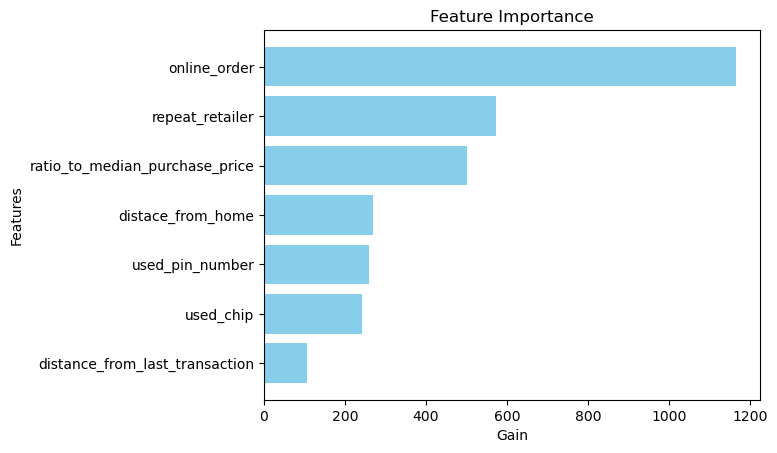

In [17]:
imprt_gain_sorted = imprt_gain.sort_values(by='Gain', ascending=True)
plt.barh(imprt_gain_sorted['Features'], imprt_gain_sorted['Gain'], color = 'skyblue')
plt.ylabel('Features')
plt.xlabel('Gain')
plt.title('Feature Importance')
plt.show() 

### Deploy Model

In [ ]:
predictor = xgb.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.xlarge",
    endpoint_name="fraud-detection-endpoint"
)

[03/25/25 18:17:21] INFO     Creating model with name: xgboost-2025-03-25-18-17-21-664              ]8;id=565137;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=496420;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4094\4094]8;;\

[03/25/25 18:17:22] INFO     Creating endpoint-config with name fraud-detection-endpoint            ]8;id=90629;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=459768;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#5937\5937]8;;\

                    INFO     Creating endpoint with name fraud-detection-endpoint                   ]8;id=953011;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=903176;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4759\4759]8;;\

----

In [ ]:
# Test data  
y_test = test.pop('target')
X_test = test

In [ ]:
predictor.serializer = CSVSerializer()
a = 20

# Test Prediction
test_data = X_test.iloc[a]
print(y_test.iloc[a])

# Covert to csv
csv_data = ",".join(map(str, test_data.values))
print("csv_data:", repr(csv_data))

response = predictor.predict(csv_data)
print(response)

In [ ]:
parsed_response = json.loads(response.decode("utf-8"))
if parsed_response < 0.5: 
    print("Transaction was legitimate")
else: 
    print("Transaction was fraudulent")

### Delete Endpoint

In [20]:
sagemaker_session = sagemaker.Session()
role = get_execution_role()
client = sagemaker_session.sagemaker_client

def delete_sagemaker_endpoint(endpoint_name):
    """
    Deletes a SageMaker endpoint.

    Args:
        endpoint_name (str): The name of the SageMaker endpoint to delete.
    """
    try:
        sagemaker_client = boto3.client('sagemaker')
        response = sagemaker_client.delete_endpoint(EndpointName=endpoint_name)
        print(f"Endpoint '{endpoint_name}' deleted successfully.")
        return response
    except Exception as e:
        print(f"Error deleting endpoint '{endpoint_name}': {e}")
    try:
        client.delete_endpoint_config(EndpointConfigName=endpoint_name)
        print("Deleted existing endpoint configuration")
    except:
        print("No endpoint configuration to delete")
        return None

In [21]:
#delete_sagemaker_endpoint('fraud-detection-endpoint')

Error deleting endpoint 'fraud-detection-endpoint': An error occurred (ValidationException) when calling the DeleteEndpoint operation: Could not find endpoint "fraud-detection-endpoint".
Deleted existing endpoint configuration
